# Entity extraction on Financial Complaints with Watson NLP

Disclaimer: This notebook is intended to be used with an environment based on software configuration _Runtime 23.1 on Python 3.10_.

This notebook demonstrates how to extract _named entities_ from financial customer complaints using Watson NLP.

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), an U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains a consumer’s narrative description of their experience if the consumer opts to share this information publicly and after the CFPB has taken steps to remove all personal information. In this notebook, you will focus on complaints that contain narrative descriptions to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/.

## What you'll learn in this notebook

Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Dictionary-based term extraction** with the _Rule-based extractor_ provided by `watson_nlp.resources.feature_extractor.RBR`. This allows you to train a custom extraction model based on given dictionaries.

- **Entity extraction** with the _Entity mentions workflow_ using the transformer-based model (`entity-mentions_transformer-workflow_multi_slate-watbert-piccollo-153m-distilled`). This workflow extracts mentions of entities like *Persion*, *Organization* or *Duration* from the input text.


## Table of Contents

1. [Before you start](#beforeYouStart)
2. [Load the complaints](#loadData)
3. [Custom term extraction using dictionaries](#dictionaries)
4. [Entity extraction](#entities)
5. [Summary](#summary)

<a id="beforeYouStart"></a>
## Before you start

You can step through the notebook execution cell by cell, by selecting Shift-Enter or you can execute the entire notebook by selecting **Cell -> Run All** from the menu. 

**Note:** If you have other notebooks currently running with the _NLP_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.


Begin by importing and initializing some helper libraries that are used throughout the notebook.

In [1]:
import os
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

In [2]:
import watson_nlp

<a id="loadData"></a>
## Load the complaints

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. For this notebook, the complaints for one month will be downloaded and only those that contain the consumer narrative text. The data is exported in CSV format. The URL to retrieve this data is:

In [3]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"

Read the data into a dataframe.

You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In the analysis, you will focus on the *Product* column and the column with the complaint text *Consumer complaint narrative*.

In [4]:
df_all = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

# In this example, we take only the first 1000 complaints in the dataset for further analysis. 
# Set df to df_all to run on the complete dataset.
df_small = df_all.head(1000)
df = df_small
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/23/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,Unauthorized Inquiries On My Account. Cant Get In Contact With Anyone From Experian.,Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,SC,29649,None,Consent provided,Web,03/23/21,Closed with explanation,Yes,NaN,4238810
1,03/30/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Account information incorrect,"I XXXX XXXX XXXX entered a consumer credit transaction with XXXX XXXX Bank on XX/XX/2017, due to this being a consumer credit transaction a finance charge was involved, 15 US code 1605 the amount of the finance charge in connection with any consumer credit transaction shall be determined as the sum of all charges. So there shouldn't be any late payments due this being a finance charge because ...",None,"EQUIFAX, INC.",CA,90620,None,Consent provided,Web,03/30/21,Closed with explanation,Yes,NaN,4258535
2,03/18/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Investigation took more than 30 days,I have filed a dispute in regards to the incorrect items on my credit report. it has been well over 30 days and I haven't received any investigation results.,None,"Bread Financial Holdings, Inc.",OH,43123,None,Consent provided,Web,03/18/21,Closed with explanation,Yes,NaN,4225032


You can look at all products that are available in the data set to do further analysis around these product groups.

<Axes: >

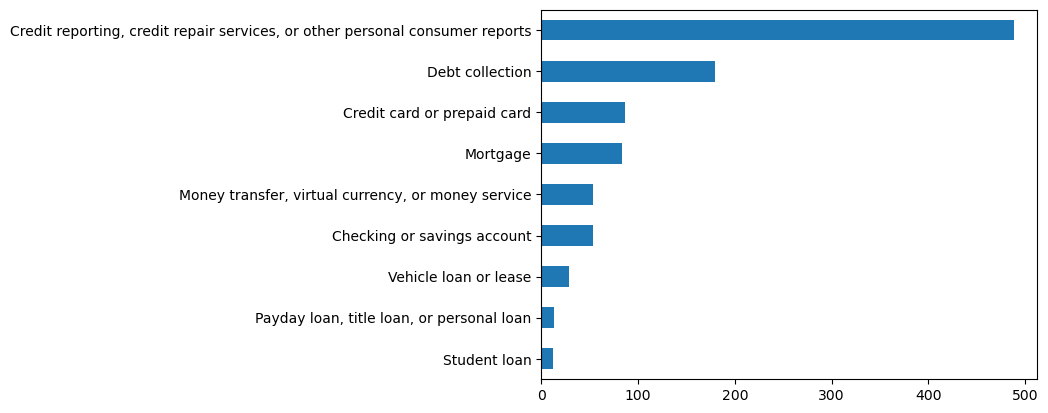

In [5]:
df['Product'].value_counts().sort_values().plot(kind='barh') 

<a id="dictionaries"></a>
## Custom term extraction using dictionaries

If you want to extract custom concepts via rule-based extraction, you can build a custom RBR model using an AQL model. However this requires knowledge of AQL. If you just want to extract custom terms or match regular expression patterns, there is a convenient way to train and run such models through `watson_nlp.resources.feature_extractor.RBR`. You only need to provide your own dictionaries or regexes and it trains an RBR model for you.

You will now create a basic dictionary that contains terms that might indicate customers suspecting a fraud concerning their financial products like the theft of a credit card.

Start with creating a folder that holds all dictionary files that you want to use for extraction.

In [6]:
import os
RBR_dicts_folder = "RBR_dicts"
os.makedirs(RBR_dicts_folder, exist_ok=True)

A dictionary can contain the dictionary terms as a flat list if all the terms are to be mapped to the same label. Alternatively, you can use a mapping dictionary that maps terms to a label. 

In this notebook, you will create a dictionary mapping file containing the fraud-related terms divided into *FRAUD* and *THEFT*. Each line has one dictionary entry.

In [7]:
fraud_file = "fraud_mappings.csv"
with open(os.path.join(RBR_dicts_folder, fraud_file), 'w') as dict:
    dict.write("\"label\", \"entry\"\n")
    dict.write("\"FRAUD\", \"fraud\"\n")
    dict.write("\"FRAUD\", \"takeover\"\n")
    dict.write("\"FRAUD\", \"skimming\"\n")
    dict.write("\"FRAUD\", \"phishing\"\n")
    dict.write("\"THEFT\", \"theft\"\n")
    dict.write("\"THEFT\", \"thief\"\n")
    dict.write("\"THEFT\", \"thieve\"\n")
    dict.write("\"THEFT\", \"steal\"\n")

In the next step, load the file as dictionary. The source dictionary path is a relative path to the created dictionary resources folder. You will use case-insensitive matching as the dictionary entries are regular words that are not likely to be miss-interpreted.

Lemma-matching will make sure that inflections of the dictionary entries will also match, for example, "steal" -> "stole", "stolen", "stealing".

In [8]:
from watson_nlp.toolkit.rule_utils import DictionaryConfig

dictionary = DictionaryConfig.load( 
    {
        'name': 'fraud_mappings',
        'source': fraud_file,
        'dict_type': 'table',
        'case': 'insensitive',
        'lemma': True,
        'mappings': {
            'columns': ['label', 'entry'],
            'entry': 'entry'
        }
    }
)

Train the RBR model using the created dictionary. This will create the unterlying AQL code.

In [9]:
trained_dict_RBR = watson_nlp.resources.feature_extractor.RBR.train(RBR_dicts_folder, language='en', dictionaries=[dictionary,])

As for the other demonstrated blocks before, create a helper method to run the RBR model on a single complaint. There is a `run()` method on the trained model, which returns the extracted concept and the span specifying the covered text.
But as you also want to see the covered text immediatly, you will access the raw response from the underlying RBR executor.

In [10]:
def extract_dictionary(complaint_text):
    RBR_result = trained_dict_RBR.executor.get_raw_response(complaint_text, language='en')
    # aggregate all matches into one array with the match label and the text evidence
    matches = []
    for view in RBR_result['annotations'].keys():
        for dict_match in RBR_result['annotations'][view]:
            matches.append(tuple((dict_match['label'], dict_match['match']['text'])))
    return matches

Now run the dictionary extraction on the complete dataframe and display the results with the complaint text.

In [11]:
# run dictionary extraction and create a dataframe holding the results
dict_matches = df[text_col].apply(lambda text: extract_dictionary(text))
dict_matches_df = pd.DataFrame(dict_matches)
dict_matches_df.rename(inplace=True, columns={text_col:'Fraud Indicators'})
# combine with the complaint dataframe
text_dict_matches_df = df[["Product", text_col]].merge(dict_matches_df, how='left', left_index=True, right_index=True)
text_dict_matches_df.head(10)

,Product,Consumer complaint narrative,Fraud Indicators
0,"Credit reporting, credit repair services, or other personal consumer reports",Unauthorized Inquiries On My Account. Cant Get In Contact With Anyone From Experian.,[]
1,"Credit reporting, credit repair services, or other personal consumer reports","I XXXX XXXX XXXX entered a consumer credit transaction with XXXX XXXX Bank on XX/XX/2017, due to this being a consumer credit transaction a finance charge was involved, 15 US code 1605 the amount of the finance charge in connection with any consumer credit transaction shall be determined as the sum of all charges. So there shouldn't be any late payments due this being a finance charge because ...",[]
2,"Credit reporting, credit repair services, or other personal consumer reports",I have filed a dispute in regards to the incorrect items on my credit report. it has been well over 30 days and I haven't received any investigation results.,[]
3,"Credit reporting, credit repair services, or other personal consumer reports","There are several accounts that do not belong to me, nor do I have a contract with. Please remove them from my credit report. Thank you.",[]
4,Mortgage,"On XX/XX/XXXX yes, almost 1 year ago I applied for a refinance and have been patiently communicating with various individuals at Elend Mortgage LLC with no resolution. I received a formal loan estimate on XX/XX/XXXX with a rate of 3.5 % and a 2nd loan estimate on XX/XX/XXXX with a rate lock of 2.75 % During the start of this process there was a two months delay, at fault of your company, where...",[]
5,Debt collection,I have disputed this account and have reached out to the XXXX XXXX times but failed. This account is being reported inaccurately and incorrectly on my credit report.,[]
6,"Credit reporting, credit repair services, or other personal consumer reports",J P Morgan Case Auto Finance is report incorrect information on my credit. Including recently updating my credit file to reflect incorrect information.,[]
7,Debt collection,"I have disputed this negative account with the credit bureaus and they have reported to confirm the account is valid. In good faith efforts to resolve this matter amicably, I demanded proof of this debt, specifically the alleged contract or other instrument bearing my signature with this company, as well as proof of authority in this manner. They have failed to comply with previous investigati...",[]
8,Mortgage,"I was contacted by Freedom Mortgage that, as a courtesy, they could reduce my monthly payment without adjusting the term. It was portrayed as a courtesy and not as a full blown refi. There were to be no closing costs and all I needed to do was answer a couple simple questions regarding my current financial status. \n\nI considered this a great service as I have two loans with Freedom Mortgage,...",[]
9,"Credit reporting, credit repair services, or other personal consumer reports","My credit score dropped 21 points in one day XX/XX/2021 even though I reduced my debt credit usage from 93 % to 77 % and have paid off a loan recently. This happened because my professional association was promoting a private student loan refinance company known as XXXX XXXX, owned by XXXX XXXX, and included a link to calculate an estimate of the interest rate one may obtain with XXXX XXXX sho...",[]


Notice that "stolen" was detected as *THEFT* as the base-form *steal* is contained in the dictionary and you used lemma-matching.

How many complaints talk about *THEFT* or *FRAUD* or both? Count the complaints for each product group and display the relative frequency: 

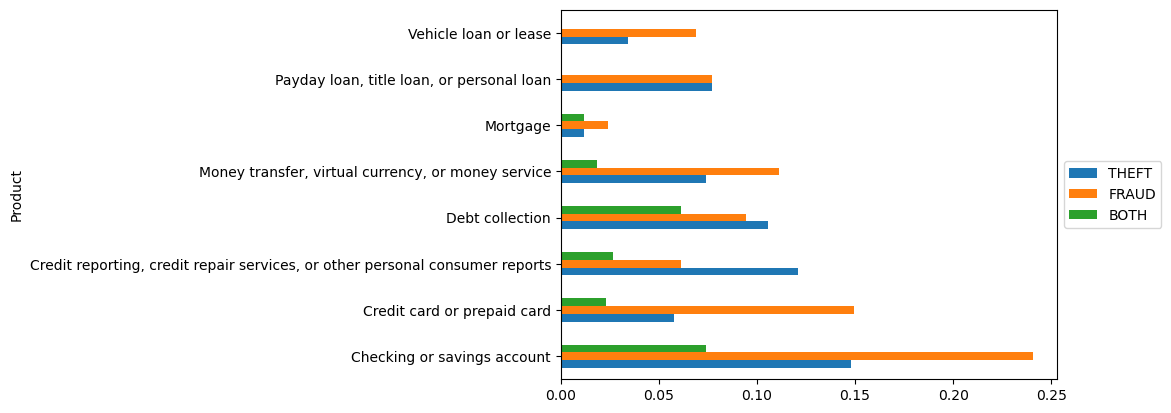

In [12]:
# create a column indicating if the complaint contains at least one *FRAUD* or *THEFT* match
text_dict_matches_df['THEFT'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'THEFT' in set([match[0] for match in matches]))
text_dict_matches_df['FRAUD'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]))
text_dict_matches_df['BOTH'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]) and 'THEFT' in set([match[0] for match in matches]))

# get the relative frequency by product group
perc_theft = text_dict_matches_df.groupby('Product')['THEFT'].value_counts(normalize=True)
perc_fraud = text_dict_matches_df.groupby('Product')['FRAUD'].value_counts(normalize=True)
perc_both = text_dict_matches_df.groupby('Product')['BOTH'].value_counts(normalize=True)
# combine the values into one dataframe
res = pd.concat([perc_theft, perc_fraud, perc_both], axis=1).reset_index().rename(columns={"level_1": "is_contained"})
# only use the counts for rows indicating a match
res = res[res['is_contained']].drop('is_contained', axis=1).set_index('Product')
res.plot.barh().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


More than 10% of the Money transfer/service complaints seem to deal with theft and over 25% of the checking or savings account complaints with fraud.

<a id="entities"></a>
## Entity extraction

The complaints contain a lot of entity mentions about entities like organizations, money, durations, etc. In this section you will learn how to use the entity mention extraction workflow, which extracts entity mentions out-of-the-box. 

Start with loading the entity mentions workflow model:

In [13]:
entity_transformer_model = watson_nlp.load('entity-mentions_transformer-workflow_multilingual_slate.153m.distilled')

The helper method first runs the entity extraction model and returns pairs of the type and the text of extracted entities:

In [14]:
def extract_entities(complaint_text):
    entity_mentions = entity_transformer_model.run(complaint_text, 'en')
    # get text and type of entities
    entities = entity_mentions.get_mention_pairs()
    return entities

Run the entity extraction model on the complaint dataframe and show the extracted entities along with the complaint text.<br/> **Note:** This cell will run for several minutes. For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. You can also use `apply` from `pandas` directly, i.e. `df[text_col].apply(..)`

In [15]:
from tqdm.notebook import tqdm
tqdm.pandas(colour='green')

In [16]:
# run entity extraction and create a dataframe holding the results
entities = df[text_col].progress_apply(lambda text: extract_entities(text))
entities_df = pd.DataFrame(entities)
entities_df.rename(inplace=True, columns={text_col:'Entities'})
# combine with our complaint dataframe
text_entities_df = df[["Product", text_col]].merge(entities_df, how='left', left_index=True, right_index=True)
text_entities_df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,Product,Consumer complaint narrative,Entities
0,"Credit reporting, credit repair services, or other personal consumer reports",Unauthorized Inquiries On My Account. Cant Get In Contact With Anyone From Experian.,"[(Experian, Organization)]"
1,"Credit reporting, credit repair services, or other personal consumer reports","I XXXX XXXX XXXX entered a consumer credit transaction with XXXX XXXX Bank on XX/XX/2017, due to this being a consumer credit transaction a finance charge was involved, 15 US code 1605 the amount of the finance charge in connection with any consumer credit transaction shall be determined as the sum of all charges. So there shouldn't be any late payments due this being a finance charge because ...","[(XXXX XXXX Bank, Organization), (XX/XX/2017, Date), (15, Number), (1605, Number)]"
2,"Credit reporting, credit repair services, or other personal consumer reports",I have filed a dispute in regards to the incorrect items on my credit report. it has been well over 30 days and I haven't received any investigation results.,"[(30 days, Duration)]"
3,"Credit reporting, credit repair services, or other personal consumer reports","There are several accounts that do not belong to me, nor do I have a contract with. Please remove them from my credit report. Thank you.",[]
4,Mortgage,"On XX/XX/XXXX yes, almost 1 year ago I applied for a refinance and have been patiently communicating with various individuals at Elend Mortgage LLC with no resolution. I received a formal loan estimate on XX/XX/XXXX with a rate of 3.5 % and a 2nd loan estimate on XX/XX/XXXX with a rate lock of 2.75 % During the start of this process there was a two months delay, at fault of your company, where...","[(XX/XX/XXXX, Date), (1 year ago, Date), (Elend Mortgage LLC, Organization), (XX/XX/XXXX, Date), (3.5 %, Percent), (2nd, Ordinal), (XX/XX/XXXX, Date), (2.75 %, Percent), (two months, Duration), (Loan Processor, JobTitle), (second, Ordinal), (Loan Processor, JobTitle), (XX/XX/XXXX, Date), (XX/XX/XXXX, Date), (Loan Processors, Organization), (Processor, JobTitle), (Loan, Product), (Processor, Or..."


Let's see what kind of entities are extracted from the complaints:

<Axes: >

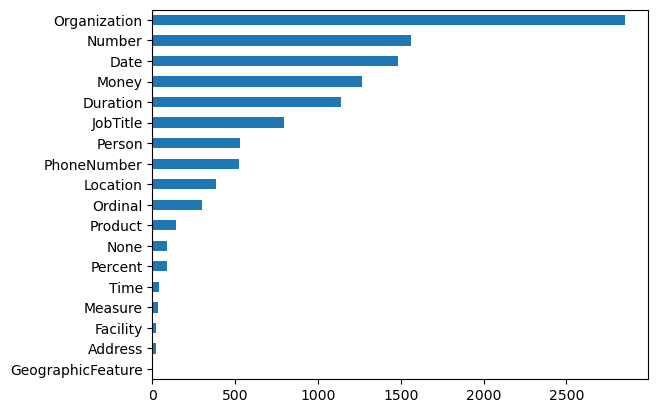

In [17]:
# helper method to extract the mention type from the (text, type) tuple
def get_entity_type(ent):
    if not pd.isna(ent):
        return ent[1]
    return 'None'

# create separate rows for each entity mention
exp_entities = text_entities_df.explode('Entities')
# extract the entity type of each mention
exp_entities['Entity Type'] = exp_entities['Entities'].apply(lambda ent: get_entity_type(ent))
# count the number of occurrences for each entity type
exp_entities['Entity Type'].value_counts().head(20).sort_values().plot(kind='barh') 

Show the relative frequency of each entity type by product:

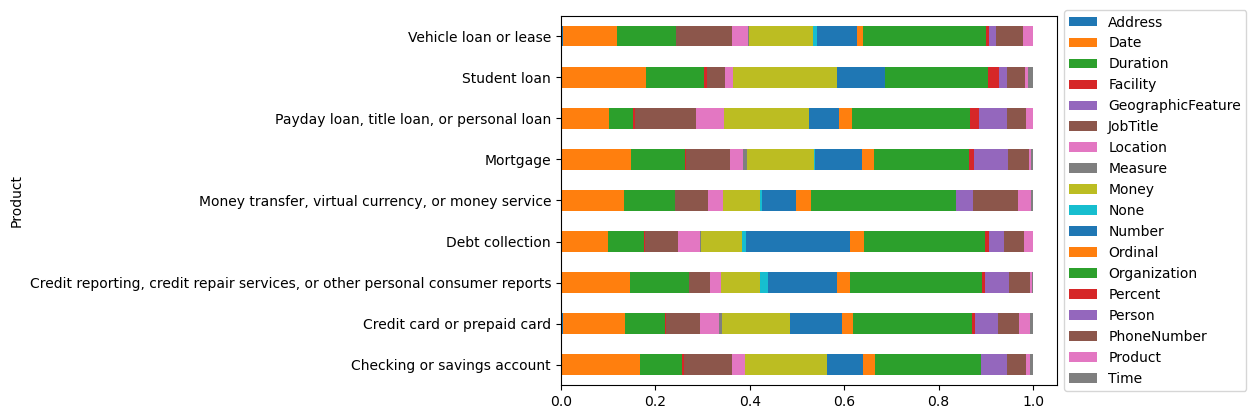

In [18]:
unstacked = exp_entities.groupby('Product')['Entity Type'].value_counts(normalize=True).unstack()
unstacked.plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

*Job Titles* are frequently mentioned in the *Vechicle loan or lease* product group and there is a high number of *Location* mentions for the product group *Debt collection*. Let's look at some sample texts for the job titles:

In [19]:
exp_entities.query('`Entity Type` == "JobTitle" and Product == "Vehicle loan or lease"').head()

,Product,Consumer complaint narrative,Entities,Entity Type
231,Vehicle loan or lease,"Tesla, my family and I went into the Tesla Dealer XXXX XXXX XX/XX/2021. The representative greeted us asked us what vehicle we were interested and offered us a test drive. Upon walking us to the car the representative started it, showed us features and in the most PREJUDICE manner purposely changed the radio station to Hip hop and rap music and stated I know yall like this type of music. ( Bec...","(dealer, JobTitle)",JobTitle
231,Vehicle loan or lease,"Tesla, my family and I went into the Tesla Dealer XXXX XXXX XX/XX/2021. The representative greeted us asked us what vehicle we were interested and offered us a test drive. Upon walking us to the car the representative started it, showed us features and in the most PREJUDICE manner purposely changed the radio station to Hip hop and rap music and stated I know yall like this type of music. ( Bec...","(rep, JobTitle)",JobTitle
231,Vehicle loan or lease,"Tesla, my family and I went into the Tesla Dealer XXXX XXXX XX/XX/2021. The representative greeted us asked us what vehicle we were interested and offered us a test drive. Upon walking us to the car the representative started it, showed us features and in the most PREJUDICE manner purposely changed the radio station to Hip hop and rap music and stated I know yall like this type of music. ( Bec...","(manager, JobTitle)",JobTitle
231,Vehicle loan or lease,"Tesla, my family and I went into the Tesla Dealer XXXX XXXX XX/XX/2021. The representative greeted us asked us what vehicle we were interested and offered us a test drive. Upon walking us to the car the representative started it, showed us features and in the most PREJUDICE manner purposely changed the radio station to Hip hop and rap music and stated I know yall like this type of music. ( Bec...","(manager, JobTitle)",JobTitle
231,Vehicle loan or lease,"Tesla, my family and I went into the Tesla Dealer XXXX XXXX XX/XX/2021. The representative greeted us asked us what vehicle we were interested and offered us a test drive. Upon walking us to the car the representative started it, showed us features and in the most PREJUDICE manner purposely changed the radio station to Hip hop and rap music and stated I know yall like this type of music. ( Bec...","(rep, JobTitle)",JobTitle


<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained model for entity extraction. You learned how easy you can extract custom terms using dictionaries.

### Authors
Simone Zerfass IBM, Germany

Alexander Lang IBM, Germany

# <hr>
Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.